In [1]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [2]:
import bisect
import datetime
import os
import sys
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import spacepy.datamodel as dm
import spacepy.plot as spp
import spacepy.toolbox as tb
import spacepy.time as spt
import scipy
from scipy.integrate import odeint
from scipy import constants
import scipy.optimize
import tqdm
import pymc3 as mc3

%version_information matplotlib, numpy, pymc3

Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 5.3.0
OS Darwin 15.6.0 x86_64 i386 64bit
matplotlib 2.0.0
numpy 1.12.1
pymc3 3.0
Wed Apr 19 17:35:29 2017 MDT

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['savefig.dpi'] = plt.rcParams['figure.dpi'] # 72
%config InlineBackend.figure_format = 'retina'

In [4]:
# import theano.tensor as T
# from theano.compile.ops import as_op

def massKgtoMeV(kg):
    """
    mass in kg
    returns mass in MeV/c**2
    """
    return kg / constants.eV * constants.c**2 / 1e6

proton_mass = massKgtoMeV(constants.m_p)

# @as_op(itypes=[T.lscalar, T.lscalar], otypes=[T.lscalar])
def getVelocity(energy, mass):
    """
    get the veocity of the particle in km/s
    KE = mc**2*(1/gamma -1), gamma = sqrt(1-v**2/c**2)
    Solve this for v gives
    v = c*sqrt(1-(mc**2/E+1)**2)
    """
    gamma = (energy/1000.+mass)/mass # keV MeV/c**2 / MeV/c**2
#     print( 'gamma', gamma)
    return constants.c*np.sqrt(1-(1/gamma)**2)  # m/s

def getTOF(vel, dist=2, offset=2):
    """
    given the particle compute its tof in ns across the distance in cm
    offset in ns
    """
    #     vel = self.velocity # m/s
    dist /= 100 # cm to m
    tof = dist/vel + offset/1e9 # in s
    # print 'vel', vel, 'tof', tof*1e9
    return tof*1e9  # ns

v = getVelocity(40, proton_mass) 
getTOF(v)

9.2250786969203258

In [5]:

data_no_thick = np.asarray([
0.7438086,	0.13370112,
0.9607652,	0.11638044,
1.2616692,	0.09759223,
1.654574,	0.08819758,
2.241563,	0.07607965,
3.0352564,	0.06749478,
4.0495057,	0.056604218,
5.484283,	0.04588714,
7.4236484,	0.04496922,
10.210965,	0.040273897,
14.467443,	0.0403625,
17.48097,	0.04234625,
25.125113,	0.046172373,
34.96821,	0.051766936,
45.679897,	0.058016192,
63.575603,	0.06504583,
88.36258,	0.07859519,
119.04462,	0.09232002,
])
data_no_thick = data_no_thick.reshape((-1,2))

def nothickdata(val):
    return tb.interpol(val, data_no_thick[:,0], data_no_thick[:,1])


data_w_thick = np.asarray([
1.0089847,	0.06927005,
1.2406048,	0.062499832,
1.477661,	0.057455737,
1.6255391,	0.053314894,
1.9056144,	0.049937215,
2.835496,	0.04180929,
3.4864058,	0.037024133,
4.1525927,	0.033719324,
5.105852,	0.030140577,
6.3785343,	0.027194738,
7.8427753,	0.025471859,
8.357662,	0.02385813,
10.276228,	0.02213867,
13.04338,	0.02213867,
17.364323,	0.021932641,
24.634321,	0.021932641,
33.320545,	0.02430847,
42.293,	0.026941655,
49.579952,	0.02770806,
53.681534,	0.02986008,
70.337814,	0.034355797,
81.15639,	0.036679573,
106.337555,	0.040652845,
134.97182,	0.0442218])
data_w_thick = data_w_thick.reshape((-1,2))


def FWHMtoGauss(fwhm):
    return fwhm/(2*np.sqrt(2*np.log(2)))

def EstraggleCoeff(ein, species='H'):
    if species.upper() == 'H':
        if ein < 15: #keV
            a0 =  6.9e-2
            a1 = -0.49
        else:
            a0 =  1.1e-2
            a1 =  0.42
    else:
        a0 =  5.1e-1
        a1 = -0.83
    return a0, a1

def EstraggleFWHM(ein, species='H', thick=0.6):
    """
    returns dE/E
    """
    dEE = nothickdata(ein)
    if species == 'H':
        return 0.05*13.
    elif species == 'He':
        return 0.05*13./1.15
    else:
        return 0.05*12.

        
    a0, a1 = EstraggleCoeff(ein, species=species)
    if species.upper() == 'H':
        if ein < 15: #keV
            return a0*np.sqrt(thick)*ein**a1
        else:
            return a0*ein**a1
    elif species == 'He':
        return a0*ein**a1/4.        
    else:
        return a0*np.sqrt(thick)*ein**a1

def EstraggleHist(ein, species='H', thick=0.6, num=1000, maskZero=True, maskUp=False):
    #print ein, ein*EstraggleFWHM(ein, species=species), FWHMtoGauss(ein*EstraggleFWHM(ein, species=species))
    tmp = np.random.normal(ein, ein*FWHMtoGauss(EstraggleFWHM(ein, species=species)), size=num)
    #tmp = np.random.normal(ein, ein*FWHMtoGauss(ein), size=num)
    #print ein*FWHMtoGauss(EstraggleFWHM(ein, species=species))
    if maskZero or maskUp:
        if maskUp:
            mask = tmp > ein
        else:
            mask = np.asarray([0])
        if maskZero:
            mask2 = tmp < 0
        else:
            mask2 = np.asarray([0])
        i=0
        while mask.sum() > 0 or mask2.sum() > 0:
            i+=1
            if mask.sum():
                #tmp[mask] = np.random.normal(ein, ein*FWHMtoGauss(ein), size=mask.sum())
                tmp[mask] = np.random.normal(ein, ein*FWHMtoGauss(EstraggleFWHM(ein, species=species)), size=mask.sum())
            if mask2.sum():
                #tmp[mask2] = np.random.normal(ein, ein*FWHMtoGauss(ein), size=mask2.sum())
                tmp[mask2] = np.random.normal(ein, ein*FWHMtoGauss(EstraggleFWHM(ein, species=species)), size=mask2.sum())
            #tmp[mask] = np.random.normal(ein, ein*FWHMtoGauss(EstraggleFWHM(ein, species=species)), size=mask.sum())
            mask = tmp > ein
            mask2 = tmp < 0
    return tmp
    
EstraggleFWHM(40)

0.65

Build a energy loss following 
Energy loss of 1–50 keV H, He, C, N, O, Ne, and Ar ions transmitted through thin carbon foils
REVIEW OF SCIENTIFIC INSTRUMENTS 77, 044501 2006


In [6]:
ESA_dee = 0.15  # 15% dE/E
ESA_e = 40e3 # 40keV
POST_e = 11e3  # 11 kV
PARTICLE_mass = proton_mass*14

with mc3.Model() as model:
    # start eh model off with what comes out of the ESA
    incidentE = mc3.Normal('incidentE', ESA_e, sd=ESA_dee, testval=ESA_e)
    # then we need to post accelerate it
    postE = mc3.Deterministic('postE', incidentE + POST_e)

    # For nitrogen from REVIEW OF SCIENTIFIC INSTRUMENTS 77, 044501 2006
    deltaE_1 = mc3.Normal('deltaE_1', 5.1e-1, sd=(0.4e-1))
    deltaE_2 = mc3.Normal('deltaE_2', -0.83, sd=(0.03))
    deltaE = (deltaE_1*(postE/1e3)**deltaE_2)
    

    estraggle = mc3.Deterministic('estraggle', postE - deltaE)
    
    #     velocity = getVelocity(postE, PARTICLE_mass)
    velocity = mc3.Deterministic('velocity', getVelocity(estraggle, PARTICLE_mass))
    #     velocity = getVelocity(estraggle, PARTICLE_mass)
    tof = mc3.Deterministic('tof', getTOF(velocity))

    
    
    start = mc3.find_MAP()
    trace = mc3.sample(4000, start=start)
    
    


Optimization terminated successfully.
         Current function value: -5.865738
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.014519: 100%|██████████| 200000/200000 [00:12<00:00, 15586.96it/s] 
Finished [100%]: Average ELBO = -0.030618
100%|██████████| 4000/4000 [00:03<00:00, 1225.08it/s]



incidentE:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  39999.999        0.144            0.003            [39999.718, 40000.285]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  39999.715      39999.902      40000.000      40000.094      40000.284


deltaE_1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.510            0.040            0.001            [0.430, 0.585]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.432          0.484          0.509          0.536          0.588


deltaE_2:

  Mean             SD               MC Error         95% HPD interval
  ---

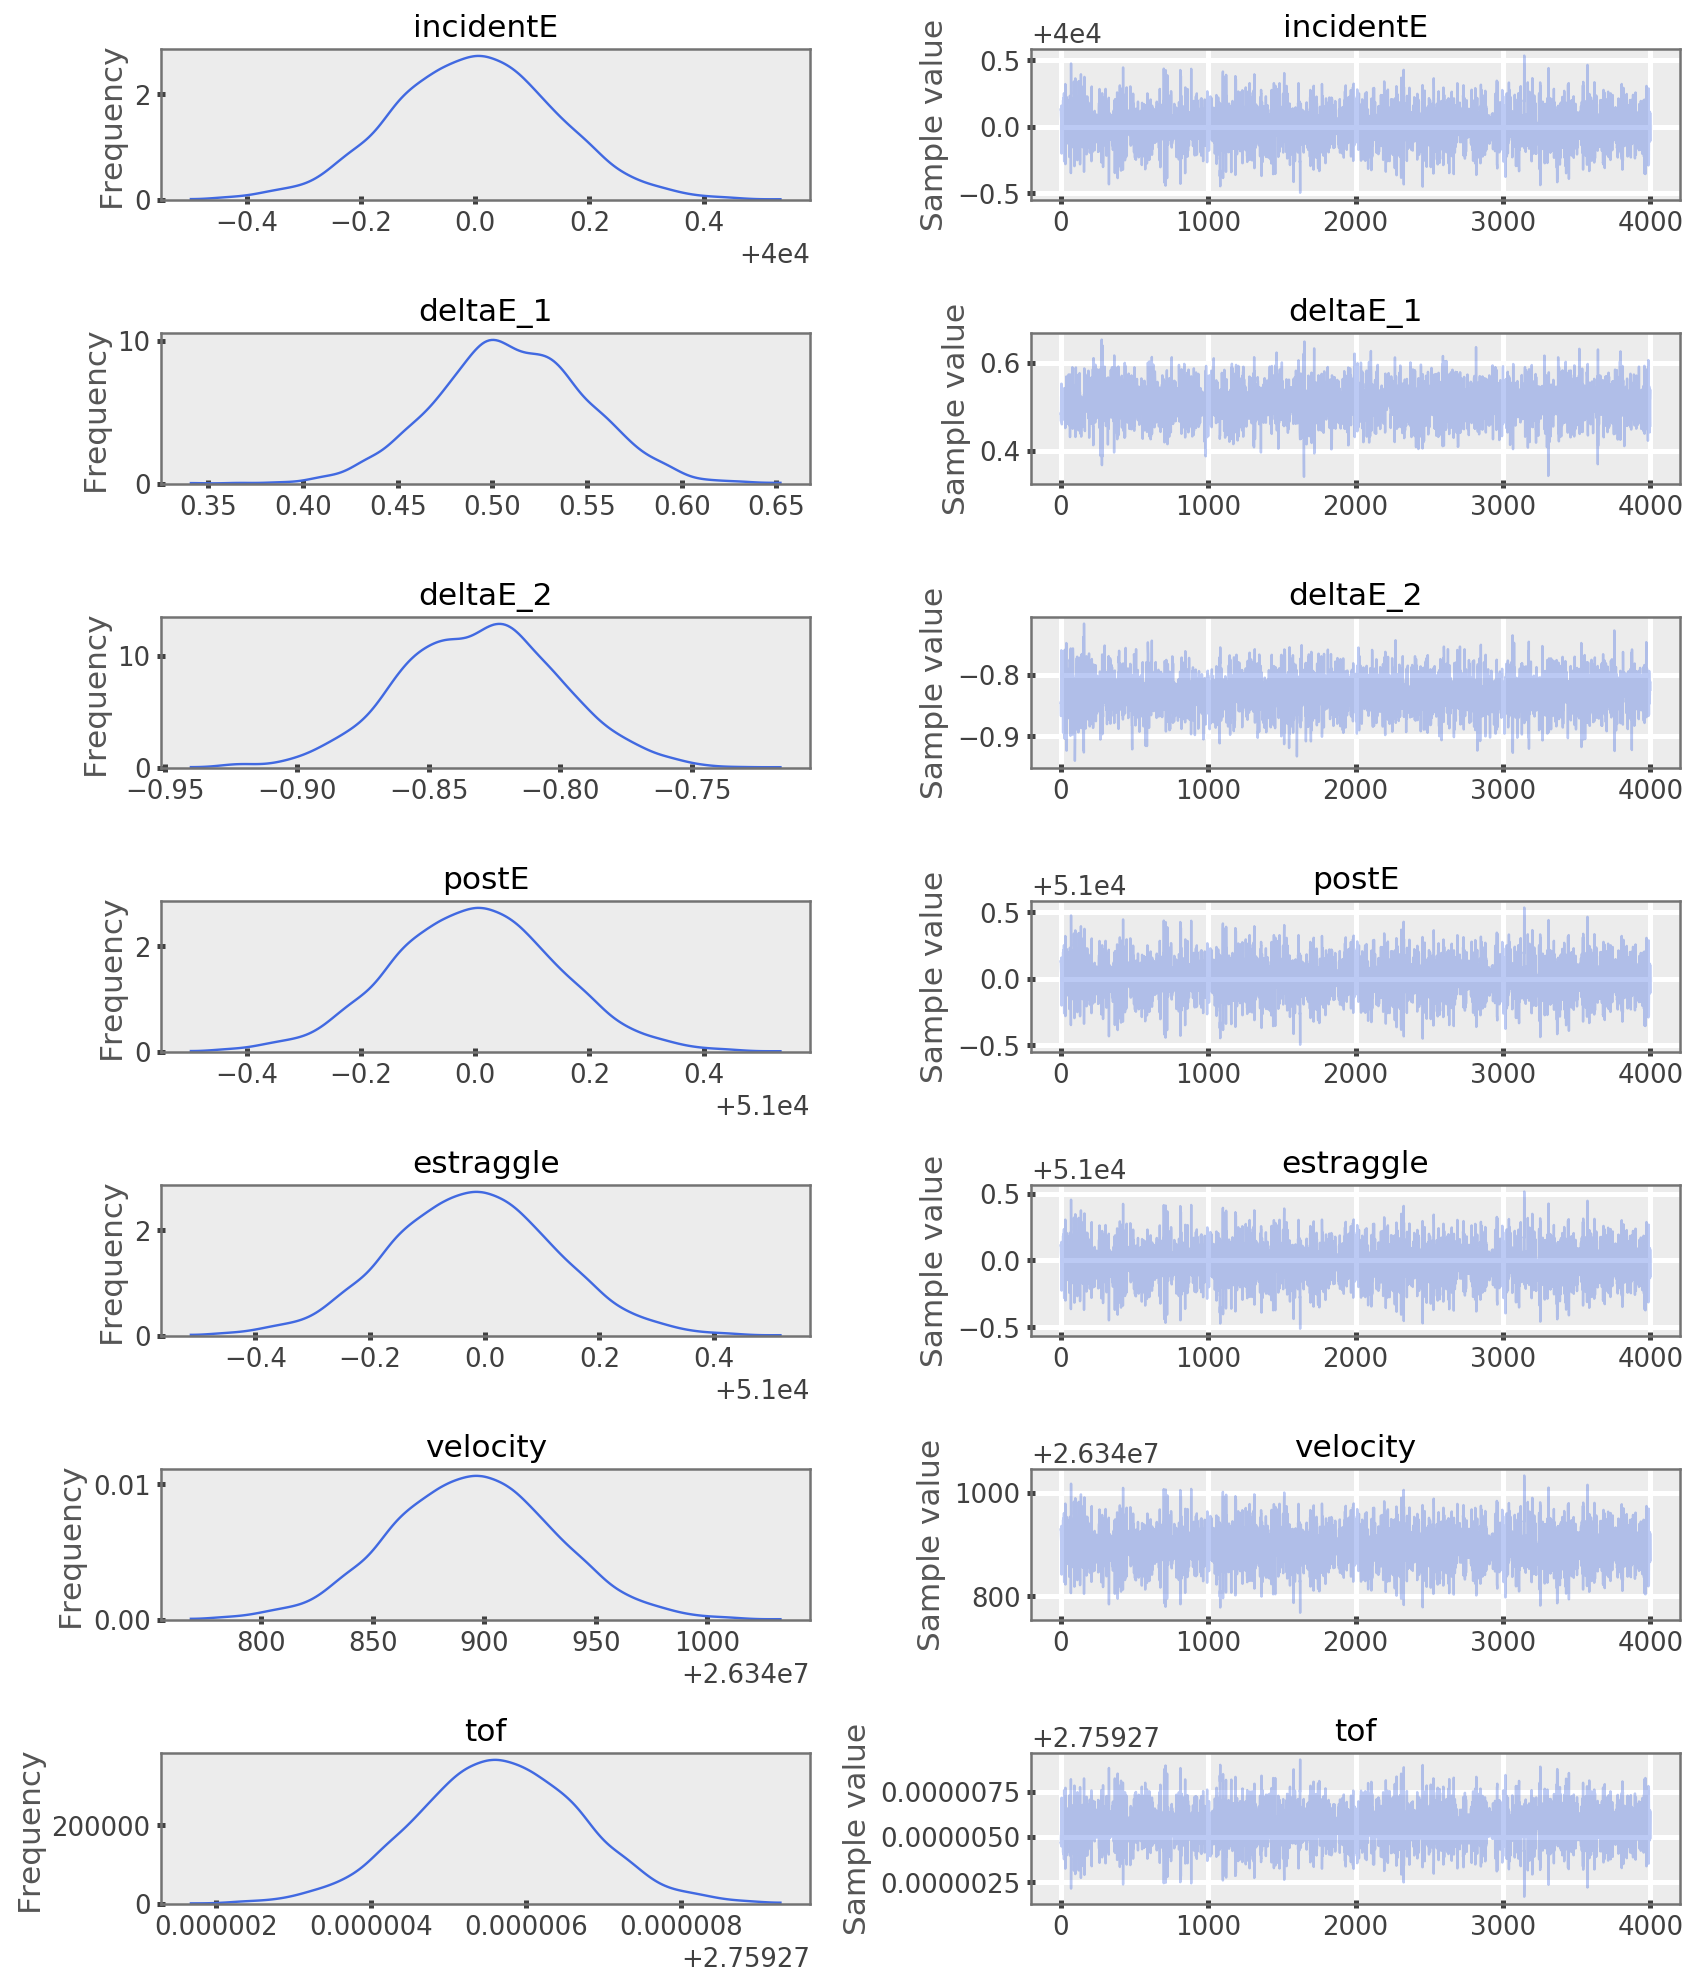

In [7]:
mc3.traceplot(trace);
mc3.summary(trace)

In [8]:
mc3

<module 'pymc3' from '/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/__init__.py'>